# Programming exercise 7: Entanglement and the transverse field Ising model

Due on Monday, 10.12.2018, 14.15h

__This exercise sheet has been solved by:__ Mathieu Kaltschmidt and Carl von Randow

### Total: 100 points

In [1]:
# load standard libraries
import numpy as np 
from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange, log)

import numpy.linalg as LA
import matplotlib.pyplot as plt  
%matplotlib inline

import time as time
import scipy.sparse as sparse
import scipy.sparse.linalg as sLA

#from qutip import (tensor, basis)

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'

### Exercise 1: Building general spin 1/2 Hamiltonians (50 points)

In the past exercises we have worked with the collective Ising model, where we could use the permutation symmetry to reduce the Hilbert space dimension from $2^N$ to $N+1$. This time we want to consider a model with nearest neighbor spin interactions, the one-dimensional transverse-field Ising model (TFIM), where the permutation symmetry no longer holds. This model is analytically solvable (see e.g. https://www.sciencedirect.com/science/article/pii/0003491670902708). For the sake of learning how to build general spin models, we will solve it here by numerical means and compare the result to the exact solution as a check. The tools you develop here, you can then apply to build any spin Hamiltonian straight forwardly. The Hamiltonian of the TFIM reads
$$
H=\sum_{i=0}^{N-1} -J\sigma_z^{(i)}\sigma_z^{(i+1)} - B \sigma_x^{(i)}
$$
where we want to use periodic boundary conditions, i.e. the Nth spin is identified with the 0th spin.

To solve it we first set up a framework for general spin 1/2 models.
We will work in the canonical product basis of states $|i_1,...,i_N\rangle$, where $i_k \in {0,1}$. This basis of course has the problem of exponential scaling of the number of basis states with particle number N. But we still want to use it to keep our approach as general as possible, which then just allows us to use up to 12 or so spins with reasonable computation time.

The recipe for conctructing general spin models is the following:

1) Build the single-spin operators $s_x$, $s_y$, $s_z$, and the 2x2 identity, $\mathbb{1}$ as sparse matrices (csr_matrix should work best).

2) Build a list of all single-spin operators acting on spin $i=0...N-1$ in the $N$-spin Hilbert space.
$$
s_\alpha^{(i)} = \mathbb{1}^{\otimes i}\otimes s_\alpha \otimes \mathbb{1}^{\otimes (N-i-1)}
$$
where $\alpha \in \{x,y,z\}$. Use the kronecker product for sparse matrices to do this. (Make sure you understand how the indexing/ordering of the matrix elements is done by kron()!)

3) Build any hermititian operator (here we want the Hamiltonian) by adding up its individual terms, using the dot product for interaction terms.

Test your implementation by calculating the ground state energy of the transverse field Ising model and comparing it to the analytical result (for even $N$)
$$
E_0^{analyt} = -\sum_{k=-(N-1)/2}^{(N-1)/2}\sqrt{1+B^2 - 2B\cos(2\pi k/N)}
$$
where the convention $J=1$ was chosen.
For N=10, scan $B$ from 0 to 2 and plot the numerical and analytical result for the ground state energy.

Also think about what the ground state should be at large $B$ and at $B=0$. 

### Solution:

#### First part of the exercise

In [2]:
#Predefinded values 
(J, N, hbar) = (1, 10, 1)

Bvals = np.linspace(0, 2, 30)

In [3]:
#Implementation of the spin matrices as  csr-sparse matrices in order Sx, Sy, Sz
SpinMatrices = [sparse.csr_matrix((hbar/2)*np.array([[0, 1]  ,[ 1, 0]])),    
                sparse.csr_matrix((hbar/2)*np.array([[0, -1j],[1j, 0]])),    
                sparse.csr_matrix((hbar/2)*np.array([[1, 0]  ,[0, -1]]))]

#2x2-Identity matrix as sparse matrix
Id = sparse.identity(2, format='csr') 

#### Second part of the exercise

In [4]:
#Constructing the single spin operator as explained in the exercise
def SingleSpinOperator(N,alpha,index):
    if index == 0:
        res = SpinMatrices[alpha]
    else:
        res = Id
    
    for SpinNum in range(1,N):
        if index == SpinNum:
            res = sparse.kron(res, SpinMatrices[alpha])
        else:
            res = sparse.kron(res, Id)          
    return res

#### Third part of the exercise

In [5]:
#building the Hamiltonian for this problem
def buildHmat(N,B):
    #Initialization as 2^N x 2^N matrix
    Hamiltonian = np.zeros((2**N,2**N))
    for i in range(N):
        Hamiltonian += -J * SingleSpinOperator(N,2,i)@SingleSpinOperator(N,2,i+1) - B * SingleSpinOperator(N,0,i)
    return Hamiltonian

In [6]:
#Analytical solution for the ground state energy for the transverse field Ising model
def TFIM_analytical(N, B, timer = False):
    if N%2==1:
        raise ValueError('This method only works for even N! Try it again.')
        
    #Initialization
    energy = 0
    
    #Extracting the computation time for further analysis 
    t1 = time.time()
    for k in range(-int((N-1)/2), int((N-1)/2 + 1)):
        energy += sqrt(1 + B**2 - 2*B*cos(2*pi*k/N))
    t2 = time.time()
    
    if timer:
        runtime = t2-t1
        print('The computation time was ', runtime, ' seconds')
        return -energy, runtime
    else: 
        return -energy

In [7]:
#Numerical computation 
def TFIM_numerical(N, B, timer = False):
    
    t1 = time.time()
    H = buildHmat(N, B)
    evals, evecs = sLA.eigs(H, 1, which = 'SR' )
    t2 = time.time()
    
    if timer:
        runtime = t2-t1
        print('The computation time was ', runtime, ' seconds')
        return evals[0].real, runtime
    else:
        return evals[0].real

In [8]:
#Storing all the energies and the corresponding runtimes (if they were computed)
def StoreResults(N, B, runtimes = False):
    if runtimes:
        results  = np.zeros((len(B), 4))
        for i in range(len(B)):
            results[i,0]=TFIM_analytical(N,B[i])[0]
            results[i,1]=TFIM_numerical(N,B[i])[0]
            results[i,2]=TFIM_analytical(N,B[i])[1]
            results[i,3]=TFIM_numerical(N,B[i])[1]
        return results
    else:
        results  = np.zeros((len(B), 2))
        for i in range(len(B)):
            results[i,0]=TFIM_analytical(N,B[i])
            results[i,1]=TFIM_numerical(N,B[i])
        return results

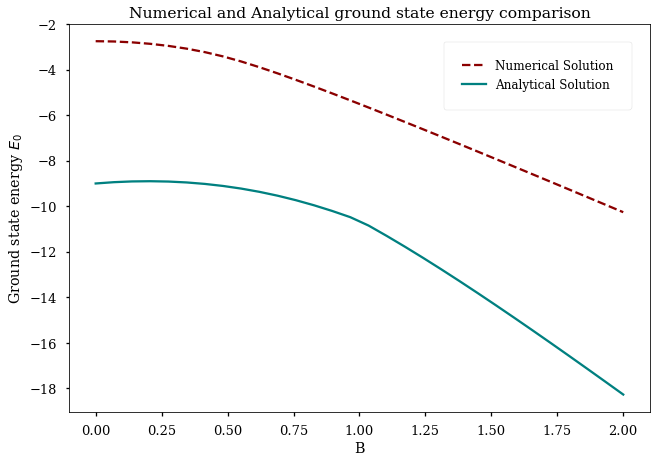

In [9]:
#Plotting the results
results = StoreResults(10,Bvals)

plt.plot(Bvals, results[:,1],label='Numerical Solution', color = 'darkred', ls = 'dashed')
plt.plot(Bvals, results[:,0],label='Analytical Solution', color = 'teal')

plt.xlabel('B')
plt.ylabel('Ground state energy $E_0$')
plt.title('Numerical and Analytical ground state energy comparison')
plt.legend(fontsize='large', borderpad=1.5, borderaxespad=1.5)

### Discussion:

Hier könnte ihre Interpretation stehen!

### Exercise 2: Taking partial traces (50 points)

The TFIM has a quantum phase transition at $B/J=1$ from a ferromagnetic to a paramagnetic phase. You can use your code from exercise 1 to see that the gap is mimimal around this value. Note that the model also has the $Z_2$ symmetry (invariance under flipping of all spins) which we saw in the collective Ising model, so you would look at the gap of ground and second excited state.
At the phase transition point, long-range correlations emerge in the ground state. An interesting feature is also that at the critical point the half-chain entanglement entropy diverges logarithmically as $N$ goes to infinity (see for example https://arxiv.org/abs/0803.3610 Fig. 3). For finite $N$ we should already see that the entanglement entropy becomes maximal approximately at the critical point.

To calculate the half-chain entanglement entropy in the ground state of the transverse Ising chain, you should proceed as follows:

1) Divide the chain into two halves and calculate the reduced state of one half, i.e., calculate the partial trace over the first or the last $N/2$ spins. The matrix element of the reduced density of a state $|\psi\rangle = \sum_i c_i |i\rangle$ (where $|i\rangle$ are the $N$-spin basis states) traced over spins $N/2$ thorugh $N-1$, i.e. over the second half, can be expressed as
$$
(\rho_{red,N/2})_{ij} = \sum_{k=0}^{2^{N/2}-1} c_{i+k*2^{N/2}}^*c_{j+k*2^{N/2}}
$$
(This might look different depending on how the states are ordered in your basis.)

2) Calculate the eigenvalues $p_i$ of $\rho_{red,N/2}$, sort them from largest to smallest. This is the entanglement spectrum. The rank of $\rho_{red,N/2}$ is called entanglement dimension. For a separable state the entanglement dimension is 1, i.e. only one eigenvalue is non-zero.

3) Calculate the von-Neumann entanglement entropy $S_E = -\sum_i p_i \log(p_i)$. Consider that some of the eigenvalues can be zero. Due to the finite numerical precision they can even turn negative. These you want to exclude from the sum. (The limit $\lim_{p\rightarrow 0} p\log(p) =0$ so we are not actually modifying the outcome significantly by neglecting small p's.)

Test your code for some cases where you know the answer, for example a separable state or a Bell pair state of 2 qubits. The qutip module also has the capability of calculating partial traces. If you are interested you can compare to this for testing.

Then calcualte the entanglement spectrum and entropy for the same parameter scan as in exercise 1. Document your observations.

### Solution:

#### First part of the exercise

In [19]:
def DensityMatrixElement(i, j, c, N): 
    """
    i, j = indices of matrix element (dtype = int)
    c = prefactor of basis decomposition (vector-like quantity)
    N = length of Ising chain
    """
    element = 0
    for k in range(int(2**(N/2))):
        element += c[int(i + k * 2**(N/2))].conj() * c[int(j + k * 2**(N/2))]    
    return element

def DensityMatrix(c,N):
    """
    Computes the entire density matrix.
    """
    rho = np.zeros((N,N))
    for j in range(N):
        for i in range(N):
            rho[i,j] = DensityMatrixElement(i, j, c, N)
    return rho
    
def Trace(c, N):
    tr = 0
    for index in range(N):
        tr += DensityMatrixElement(index, index, c, N)  
    return tr

#### Second part of the exercise

In [27]:
#Calculating the eigenvalues of the reduced density matrix
def EntanglementSpectrum(rho, timer = False):
    """
    rho = density matrix.  
    The output is a list, sorted from the largest to the smallest eigenvalue of rho.
    """
    t1 = time.time()
    evals, evecs = sLA.eigs(rho)
    evals = sorted(evals.real)[::-1]
    t2 = time.time()
    
    if timer:
        runtime = t2-t1
        print('The computation time was ', runtime, ' seconds')
        return evals , runtime
    else:
        return evals

#### Third part of the exercise

In [28]:
#Definition of the von-Neumann entanglement entropy
def EntanglementEntropy(p):
    """
    p = eigenvalues of the entanglement spectrum (array-like)
    The function determines the von-Neumann entanglement entropy for the specific system.
    """
    entropy = 0
    for i in range(len(p)):
        if p[i] > 2e-16: #float64 accuracy 
            entropy += p[i] * log(p[i])
    return -entropy

### Explicit calculation for 2-qubit states (Bell pair)

In [29]:
#Defining the basis state decomposition for this problem
N = 10
c = np.ones(2**N) / sqrt(2**N)

rho_bell_pair = DensityMatrix(c,N)


[[ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]
 [ 0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125
   0.03125  0.03125]]
[0.3125, 6.7869301431444834e-35, -1.8709352970645

In [13]:
rho_red = np.array([ np.array([DensityMatrixElement(i, j, c, N) for i in range(N) ]) for j in range(N)])

-1845.862718654007